<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W2D4_T1_T2/tutorials/W2D4_OptimalControl/W2D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 4, Tutorial 2
# Optimal Control for Continuous State

__Content creators:__ Zhengwei Wu, Shreya Saxena, Xaq Pitkow

__Content reviewers:__ Karolina Stosio, Roozbeh Farhoodi, Matt Krause and Michael Waskom


# Tutorial objectives
In this tutorial, we will implement a continuous control task: you will design control inputs for a linear dynamical system to reach a target state. The state here is continuous-valued, i.e. takes on any real number from $-\infty$ to $\infty$.

You have already learned about control for binary states in Tutorial 1, and you have learned about stochastic dynamics, latent states, and measurements yesterday. Now we introduce you to the new concepts of designing a controller with full observation of the state (linear qudratic regulator - LQR), and under partial observability of the state (linear quadratic gaussian - LQG).

The running example we consider throughout the tutorial is a cat trying to catch a mouse in space, using its handy little jet pack to navigate. 

---
# Setup  
Please execute the cells below to initialize the notebook environment.


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import isclose

In [2]:
#@title Figure Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


In [3]:
#@title Helper functions

# Helper function for plotting
def plot_vs_time(s, slabel, color, goal=None):        
    plt.plot(s, color, label = slabel)
    if goal is not None:
      plt.plot(goal, 'm', label = 'goal $g$')
    plt.xlabel("time", fontsize =14)
    plt.legend(loc="upper right")

def test_lds_class(lds_class):
    from math import isclose
    ldsys = lds_class(T=2, ini_state=2., noise_var=0.)
    all_good = True
    if not isclose(ldsys.dynamics(.9)[1], 1.8):
        print("'dynamics' method is not correctly implemented!")
        all_good = False
    if not isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
        print("'dynamics_openloop' method is not correctly implemented!")
        all_good = False
    if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
        print("s[t] in 'dynamics_closedloop' method is not correctly implemented!")
        all_good = False
    if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
        print("a[t] in 'dynamics_closedloop' method is not correctly implemented!")
        all_good = False
    ldsys.noise_var = 1.
    if isclose(ldsys.dynamics(.9)[1], 1.8):
        print("Did you forget to add noise to your s[t+1] in 'dynamics'?")
        all_good = False
    if isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
        print("Did you forget to add noise to your s[t+1] in 'dynamics_openloop'?")
        all_good = False
    if isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
        print("Did you forget to add noise to your s[t+1] in 'dynamics_closedloop'?")
        all_good = False
    if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
        print("Your input a[t] should not be noisy in 'dynamics_closedloop'.")
        all_good = False
    if all_good:
        print('Well Done!')

def test_lqr_class(lqr_class):
    from math import isclose
    lqreg = lqr_class(T=2, ini_state=2., noise_var=0.)
    lqreg.goal = np.array([-2, -2]) 
    s = np.array([1, 2])
    a = np.array([3, 4])
    all_good = True
    if not isclose(lqreg.calculate_J_state(s), 25):
        print("'calculate_J_state' method is not correctly implemented!")
        all_good = False
    if not isclose(lqreg.calculate_J_control(a), 25):
        print("'calculate_J_control' method is not correctly implemented!")
        all_good = False
    if all_good:
        print('Well Done!')


## <font color='red'>Important Notes</font>

This tutorial is interactive and has many helper functions in the hidden cells so you can focus more on the intuition and understanding of main parameter dynamics. (Feel free to inspect hidden code everywhere.)
Keep in mind a few things when you encounter an [<< interactive] cell:
*   Execute the cell to activate the widgets (there is a slight change in the button when activated). If you change anything in the previous code (e.g. parameters), you need to execute the cell again.
*   You need to press <font color='lightgreen'>Run simulation</font> to update the plots every time you change a parameter. Simulations may take a few seconds, so sometimes you need to run the simulation twice to see the update properly.
*   If you encounter any errors or unexpected results, you might have missed running a helper cell. In this case, you can select the cell with the error and choose *Runtime*>*Run before* from Colab's menu bar, which will execute all the cells prior to the selected cell.
Enjoy.


---
# Section 1: Exploring a Linear Dynamical System (LDS) with Open-Loop and Closed-Loop Control

Video available at https://youtube.com/watch?v=MLUTR8z16jI


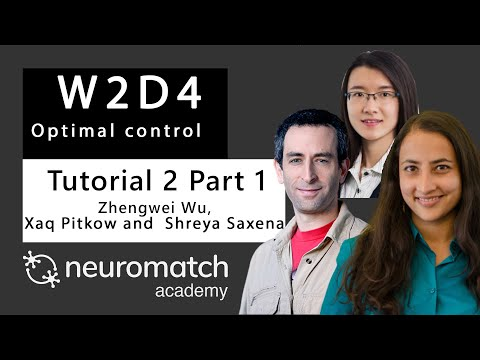

In [4]:
#@title Video: Flying Through Space
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='MLUTR8z16jI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


In this example, a cat is trying to catch a mouse in space. The location of the mouse is the goal state $g$, here a static goal. Later on, we will make the goal time varying, i.e. $g(t)$. The cat's location is the state of the system $s_t$. The state has its internal dynamics: think of the cat drifting slowly in space. These dynamics are such that the state at the next time step $s_{t+1}$ are a linear function of the current state $s_t$. There is some environmental noise (think: meteorites) affecting the state, here modeled as gaussian noise $w_t$.

The control input or action $a_t$ is the action of the jet pack, which has an effect $Ba_t$ on the state at the next time step $s_{t+1}$. In this tutorial, we will be designing the action $a_t$ to reach the goal $g$, with known state dynamics.

Thus, our linear discrete-time system evolves according to the following equation:

\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \tag{1}\\
s_{0} &=& s_{init}
\end{eqnarray*}

with 

$t$: time step, ranging from $1$ to $T$, where $T$ is the time horizon.

$s_t$: state at time $t$ 

$a_t$: action at time $t$ (also known as control input)

$w_t$: gaussian noise at time $t$

$D$ and $B$: parameters of the linear dynamical system. 

For simplicity, we will consider the 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. Specifically, $D$ and $B$ are scalars.

We will consider the goal $g$ to be the origin, i.e. $g=0$, for Exercises 1 and 2. Note that if the state dynamics are stable, the state reaches $0$ in any case. This is a slightly unrealistic situation for the purposes of simplicity, but we will see more realistic cases later on with $g \neq 0$ in Exercise 3.

**Stability** \\
The system is stable, i.e. the output remains finite for any finite initial condition $s_{init}$, if $|D|<1$.

**Control** \\
In *open-loop control*, $a_t$ is not a function of $s_t$. In *closed-loop linear control*, $a_t$ is a linear function of the state $s_t$. Specifically, $a_t$ is the control gain $L_t$ multiplied by $s_t$, i.e. $a_t=L_t s_t$. For now, you will explore these equations, and later on, you will *design* $L_t$ to reach the goal $g$.


### Exercise 1.1: Implement state evolution equations


Implement the state evolution equations in the class methods as provided below, for the following cases: \\
(a) no control: `def dynamics` \\
(b) open-loop control: `def dynamics_openloop` \\
(c) closed-loop control: `def dynamics_closedloop` \\

*Tip: refer to Equation (1) above.*

In [5]:
# Complete the LDS class

class LDS:
    def __init__(self, T: int, ini_state: float, noise_var: float):
        self.T = T  # time horizon
        self.ini_state = ini_state
        self.noise_var = noise_var

    def dynamics(self, D: float):
        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)

        for t in range(self.T - 1):
            ####################################################################
            ## Insert your code here to fill with the state dynamics equation
            ## without any control input
            ## complete the function and remove
            raise NotImplementedError("Exercise: Please complete 'dynamics'")
            ####################################################################
            s[t + 1] = ...
        return s

    def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)

        for t in range(self.T - 1):
            ####################################################################
            ## Insert your code here to fill with the state dynamics equation 
            ## with open-loop control input a[t]
            ## complete the function and remove
            raise NotImplementedError("Please complete 'dynamics_openloop'")
            ####################################################################
            s[t + 1] = ...
        return s

    def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)
        a = np.zeros(self.T)

        for t in range(self.T - 1):
            ####################################################################
            ## Insert your code here to fill with the state dynamics equation 
            ## with closed-loop control input as a function of control gain L.
            ## complete the function and remove
            raise NotImplementedError("Please complete 'dynamics_closedloop'")
            ####################################################################
            a[t] = ...
            s[t + 1] = ...
        return s, a

# uncomment the line below to test your class
# test_lds_class(LDS)

In [6]:
# to_remove solution

class LDS:
    def __init__(self, T: int, ini_state: float, noise_var: float):
        self.T = T  # time horizon
        self.ini_state = ini_state
        self.noise_var = noise_var

    def dynamics(self, D: float):

        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)

        for t in range(self.T - 1):
            s[t + 1] = D * s[t] + noise[t]
        return s

    def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)

        for t in range(self.T - 1):
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        return s

    def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

        s = np.zeros(self.T)  # states initialization
        s[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.T)
        a = np.zeros(self.T - 1)

        for t in range(self.T - 1):
            a[t] = L[t] * s[t]
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        return s, a


You will visualize the effect of different kinds of control inputs in Exercise 1.2.

### Exercise 1.2: Explore no control vs. open-loop control vs. closed-loop control

(a) No control: simulate just the state dynamics without any control input. What if the system is unstable (D>1)?

(b) Open-loop: Design an open-loop control input while knowing the initial state, to reach a goal of $g=0$ in one time step.

(c) Closed-loop: Design a closed-loop control input to reach the goal $g=0$ in one time step. Notice that you are effectively changing the system dynamics.


In [7]:
#@title << Interactive
#@markdown Play around (attentively) with **`a`** and **`L`** to see the effect on the open-loop controlled and closed-loop controlled state.

def simulate_lds(D=0.95, L=-0.3, a=-1., B=2., noise_var=0.1, T=50, ini_state=2.):
    # linear dynamical system
    lds = LDS(T, ini_state, noise_var)

    # No control
    s_no_control=lds.dynamics(D)

    # Open loop control
    at = np.append(a, np.zeros(T-1))
    s_open_loop = lds.dynamics_openloop(D, B, at)

    # Closed loop control
    Lt =  np.zeros(T) + L
    s_closed_loop, a_closed_loop = lds.dynamics_closedloop(D, B, Lt)

    plt.figure(figsize=(10, 6))
    plt.plot(s_no_control, 'b', label = 'No control')
    plt.plot(s_open_loop, 'g', label = 'Open Loop with a = {}'.format(a))
    plt.plot(s_closed_loop, 'r', label = 'Closed Loop with L = {}'.format(L))
    plt.plot(np.zeros(T), 'm', label = 'goal')
    plt.title('LDS State Evolution')
    plt.ylabel('state', fontsize = 14)
    plt.xlabel('time', fontsize = 14)
    plt.legend(loc="upper right")
    plt.show()

widget=interactive(simulate_lds, {'manual': True},
                D = (.85, 1.05, .1),
                L = (-0.6, 0., .3),
                a = (-2., 1., 1.),
                B = (1., 3., 1.),
                noise_var = (0., 0.2, .1),
                T = fixed(50),
                ini_state = (2., 10., 4.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

In Exercise 1.2, you should have noticed the following:
* No control: the dynamics parameter $D$ controls how fast the dynamics decay towards $0$, for $-1<D<1$ (stable system). For $D>1$ (unstable system), you should have noticed that the 'no control' state (blue curve) explode, i.e. $s_t \rightarrow \infty$. 

* Open-loop control: While the open-loop state (green curve) may reach the goal quickly, it may not stay at the goal but diffuse away, especially in high-noise conditions. If you don't see this, run the code in Exercise 1.2 multiple times to simulate different trials, and you should see this in some trials.

* Closed-loop control: The closed-loop state (red curve) reaches the goal and stays there even in the presence of noise. Remember that in closed-loop control, we have $a_t=L_t s_t$. Note that with a constant control gain $L_t \equiv L$, if we manipulate our state evolution equations, we have the following *closed-loop* dynamics.
\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \\
&=& Ds_t + B(Ls_t) + w_t \\
&=& (D+BL)s_t + w_t \tag{2}
\end{eqnarray*}
Thus, the stability of the closed-loop system now depends on the value of $D+BL$. If $|D+BL|<1$, our closed-loop system will be stable.
More generally, you can view the role of a closed-loop control input as changing the system *dynamics* in an optimal way to reach the goal.

### Exercise 1.3: Exploring the closed-loop setting further
In the closed-loop setting, set the control gain to be a constant over time, as in Exercise 1.2. Explore this parameter $L$ and visualize (a) the dynamics and (b) the mean squared error (MSE) between the current state and the goal. Find the control gain that gives you the minimum MSE. This is the optimal control gain if your only objective is to minimize this MSE. Can you figure out what this should be from Equation (2)?

We will first visualize the system dynamics with the optimal control gain, and then you will find the following. \\
* an over-ambitious control gain that causes oscillations in the system.
* an under-ambitious control gain that gets us to our goal very slowly.

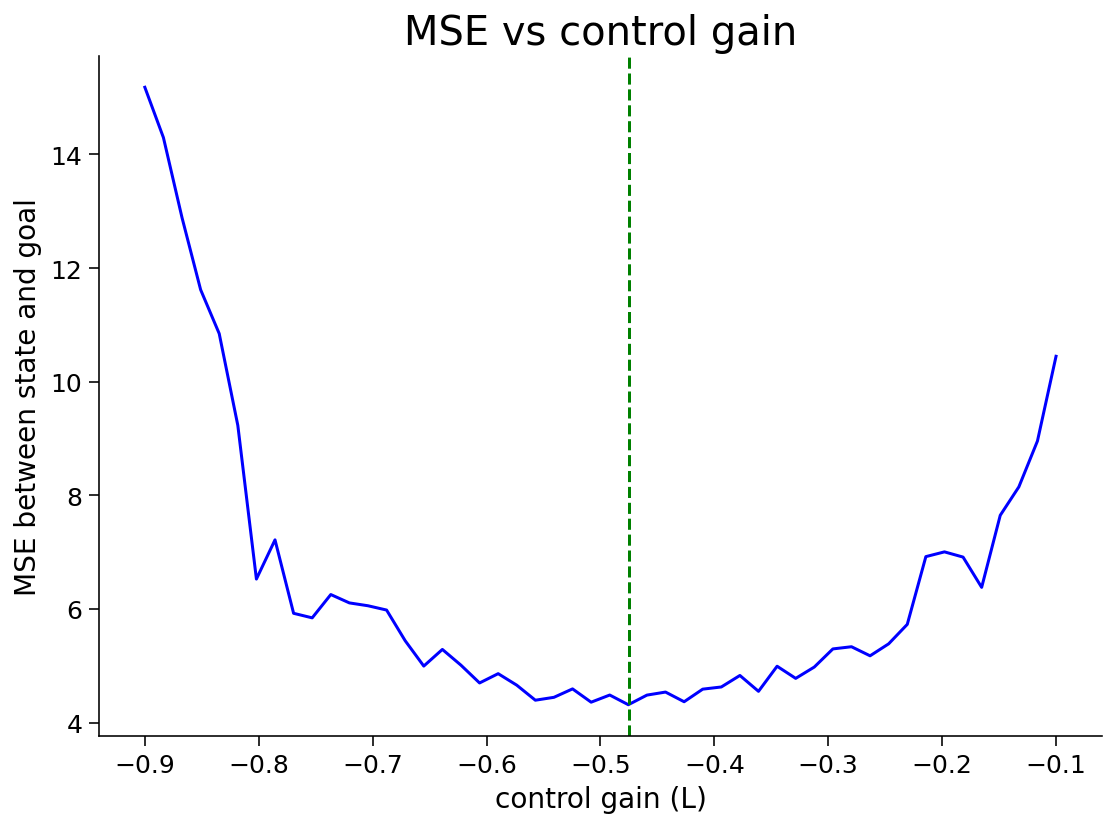

In [8]:
#@title << Run cell to visualize MSE between state and goal, as a function of control gain
def calculate_plot_mse():
    D, B, noise_var, T, ini_state = 0.95, 2., 0.1, 50, 2.
    control_gain_array = np.linspace(0.1, 0.9, T)
    mse_array = np.zeros(control_gain_array.shape)
    for i in range(len(control_gain_array)):
        lds = LDS(T, ini_state, noise_var)
        L = - np.ones(T) * control_gain_array[i]
        s, a = lds.dynamics_closedloop(D, B, L)
        mse_array[i] = np.sum(s ** 2)

    plt.figure(figsize=(8, 6))
    plt.plot(-control_gain_array, mse_array, 'b')
    plt.axvline(x=-D/B, color='g', linestyle='--')
    plt.xlabel("control gain (L)", fontsize =14)
    plt.ylabel("MSE between state and goal" , fontsize =14)
    plt.title("MSE vs control gain", fontsize =20)
    plt.show()

calculate_plot_mse()

You should see a *U* shaped curve, with a clear minimum MSE (If you don't see this, adjust the minimum and maximum values for the control gain until you do). The control gain at which the minimum MSE is reached, is the 'optimal' constant control gain for minimizing MSE, here called the numerical optimum.

In a green dashed line is shown $L = -\frac{D}{B}$. Why is this the theoretical optimal control gain for minimizing MSE of the state $s$ to the goal $g=0$? Please take a look at Equation (2).

Now, let's visualize the evolution of the system as we change the control gain. We will start with the optimal gain (the control gain that gets us the minimum MSE), and then explore over- and under- ambitious values.

In [9]:
#@title << Interactive
#@markdown Explore different values of control gain **`L`** (close to optimal, over- and under- ambitious) \\

def simulate_L(L:float=-0.45):
    D, B, noise_var, T, ini_state = 0.95, 2., 0.1, 50, 2.
    lds = LDS(T, ini_state, noise_var)
    # Closed loop control with the numerical optimal control gain
    Lt = np.ones(T) * L
    s_closed_loop_choice, _ = lds.dynamics_closedloop(D, B, Lt)
    # Closed loop control with the theoretical optimal control gain
    L_theory = - D / B * np.ones(T)
    s_closed_loop_theoretical, _ = lds.dynamics_closedloop(D, B, L_theory)
    # Plotting closed loop state evolution with both theoretical and numerical optimal control gains
    plt.figure(figsize=(10, 6))
    plot_vs_time(s_closed_loop_theoretical,
                 'Closed Loop (Theoretical optimal control gain)','b')
    plot_vs_time(s_closed_loop_choice,
                 'Closed Loop (your choice of L = {})'.format(L), 'g',
                 goal=np.zeros(T))
    plt.title('Closed Loop State Evolution')
    plt.show()

widget=interactive(simulate_L, {'manual': True}, L = (-1.05, 0.051, .1))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'

controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

In Exercise 1.3, you should have seen that the optimal control gain takes a short amount of time to get to the goal, and then stays there. We can try to get to the goal in an even shorter time using an 'over-ambitious' control gain, but this may actually overshoot the goal and may cause oscillations in the system, thus increasing the MSE. On the other hand, an 'under-ambitious' control gain takes a longer time to get to the goal and thus increases the MSE.

---
#Section 2: Designing an optimal control input using a linear quadratic regulator (LQR)

Video available at https://youtube.com/watch?v=NZSwDy7wtIs


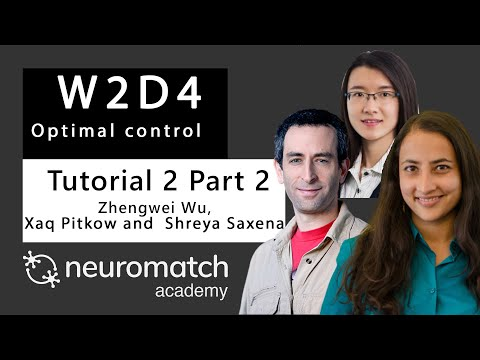

In [10]:
#@title Video: Linear quadratic regulator (LQR)
video = YouTubeVideo(id='NZSwDy7wtIs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Constraints on the system
If you explored different values for $s_{init}$ above, you would have seen very large values for $a_t$ in order to get to the mouse in a short amount of time. What if you have constraints on how much fuel you can use in one time step? 

Moreover, in Exercise 1, we had restricted ourselves to a static control gain $L_t \equiv L$. How would we vary it if we could?

This leads us to a more principled way of designing the optimal control input.
### Setting up a cost function 

In a finite-horizon LQR problem,  the cost function is defined as: 

\begin{eqnarray}
J({\bf s},{\bf a}) &=& J_{state}({\bf s}) + \rho J_{control}({\bf a}) \\
 &=& \sum_{t = 0}^{T} (s_{t}-g)^2 + \rho \sum_{t=0}^{T-1}a_{t}^2 \tag{3}
\end{eqnarray}

where $\rho$ is the weight on the control effort cost, as compared to the cost of not being at the goal. Here, ${\bf a} = \{a_t\}_{t=0}^{T-1}$, ${\bf s} = \{s_t\}_{t=0}^{T}$. This is a quadratic cost function. In Exercise $2$, we will only explore $g=0$, in which case $J_{state}({\bf s})$ can also be expressed as $\sum_{t = 0}^{T} s_{t}^2$. In Exercise $3$, we will explore a non-zero time-varying goal.

The goal of the LQR problem is to find control ${\bf a}$ such that $J({\bf s},{\bf a})$ is minimized. The goal is then to find the control gain at each time point, i.e.,

$$ \text{argmin} _{\{L_t\}_{t=0}^{T-1}}  J({\bf s},{\bf a}) \tag{4} $$ 

where $a_t = L_t s_t$.

### Solving LQR
The solution to Equation (4), i.e. LQR for a finite time horizon, can be obtained via Dynamic Programming. For details, check out [this lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr.pdf).

For an infinite time horizon, one can obtain a closed-form solution using Riccati equations, and the solution for the control gain becomes time-invariant, i.e. $L_t \equiv L$. We will use this in Exercise 4. For  details, check out [this other lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr-ss.pdf).

Additional reference for entire section: \\
[Bertsekas, Dimitri P. "Dynamic programming and optimal control". Vol. 1. No. 2. Belmont, MA: Athena scientific, 1995.](http://www.athenasc.com/dpbook.html)


### Exercise 2.1: Implement the cost function
The cost function $J_{control}({\bf s}, {\bf a})$ can be divided into two parts: $J_{state}({\bf s})$ and $J_{control}({\bf a})$. 

Code up these two parts in the class methods `def calculate_J_state` and `def calculate_J_control` in the following helper class for LQR. 


In [11]:
# Complete the helper class LQR for LQR

class LQR(LDS):
    def __init__(self, T, ini_state, noise_var):
        super().__init__(T, ini_state, noise_var)
        self.goal = np.zeros(T)  # The class LQR only supports g=0

    def control_gain_LQR(self, D, B, rho):
        P = np.zeros(self.T)  # Dynamic programming variable
        L = np.zeros(self.T - 1)  # control gain 
        P[-1] = 1

        for t in range(self.T - 1):
            P_t_1 = P[self.T - t - 1]
            P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (
                    rho + P_t_1 * B) * B**2 * P_t_1 * D)

            L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
        return L

    def calculate_J_state(self, s:np.ndarray):
        ########################################################################
        ## Insert your code here to calculate J_state(s) (see Eq. 3)
        ## complete the function and remove
        raise NotImplementedError("Please complete 'calculate_J_state'")
        ########################################################################
        J_state = ...
        return J_state

    def calculate_J_control(self, a:np.ndarray):
        ########################################################################
        ## Insert your code here to calculate J_control(a) (see Eq. 3).
        ## complete the function and remove
        raise NotImplementedError("Please complete 'calculate_J_control'")
        ########################################################################
        J_control = ...
        return J_control

# uncomment the line below to test your class
# test_lqr_class(LQR)

In [12]:
# to_remove solution

class LQR(LDS):
    def __init__(self, T, ini_state, noise_var):
        super().__init__(T, ini_state, noise_var)
        self.goal = np.zeros(T)  # The class LQR only supports g = 0

    def control_gain_LQR(self, D, B, rho):
        P = np.zeros(self.T)  # Dynamic programming variable
        L = np.zeros(self.T - 1)  # control gain
        P[-1] = 1

        for t in range(self.T - 1):
            P_t_1 = P[self.T - t - 1]
            P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (
                    rho + P_t_1 * B) * B**2 * P_t_1 * D)

            L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
        return L

    def calculate_J_state(self, s:np.ndarray):
        J_state = np.sum((s - self.goal)**2)
        return J_state

    def calculate_J_control(self, a:np.ndarray):
        J_control = np.sum(a**2)
        return J_control

### Exercise 2.2: LQR to the origin 

In this exercise, we will design an LQR controller to track a static goal at $g=0$. \\
(a) Pick a value for $\rho$ that will get you the same cost and control gain as Exercise 1. \\
(b) Pick a large value for $\rho$ and see the effect on the action. \\
(d) Try increasing the rho to 2. What do you notice? \\
(e) For different values of $\rho$, solve for the LQR controller, and plot the trajectory of states.

In [13]:
#@title << Interactive
#@markdown Play around with **`rho`** and try to answer the questions above. \\
 
def simulate_rho(rho=1.):
    D, B, T, ini_state, noise_var = 0.9, 2., 50, 2., .1  # state parameter
    lqr = LQR(T, ini_state, noise_var)
    L = lqr.control_gain_LQR(D, B, rho)
    s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)

    plt.figure(figsize=(14, 4))
    plt.suptitle('LQR Control for rho = {}'.format(rho), y=1.05)

    plt.subplot(1, 3, 1)
    plot_vs_time(s_lqr,'State evolution','b',goal=np.zeros(T))
    plt.ylabel('State $s_t$')

    plt.subplot(1, 3, 2)
    plot_vs_time(a_lqr,'LQR Action','b')
    plt.ylabel('Action $a_t$')

    plt.subplot(1, 3, 3)
    plot_vs_time(L,'Control Gain','b')
    plt.ylabel('Control Gain $L_t$')

    plt.tight_layout()
    plt.show()

widget=interactive(simulate_rho, {'manual': True}, rho = (0., 2., 0.5))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'

controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

In Exercise 2.2, you should have noticed that 
* $\rho=0$ will get you the same cost and control gain as in Exercise 1. Look at the equations for the cost to see why. \\
* A small value for $\rho$ will have a similar solution as in (a), with potentially large values for $|a_t|$. 
* A large value for $\rho$, say $\rho=2$ will lead to small values for $|a_t|$. 
* The control gain becomes more time-varying (as opposed to fairly static) for large $\rho$. For some parameter values, ex. $D = 0.9$, $B = 2$ and $\rho = 2$, $L_t$ oscillates during the entire trajectory in order to keep $|a_t|$ low.

### Exercise 2.3: Visualizing the tradeoff between state cost and control cost
In Exercise 2.1, you should have provided the code for $J_{state}$ and $J_{control}$ in the class methods for the class LQR. 

We will now plot them against each other for varying values of $\rho$ to explore the tradeoff between state cost and control cost.

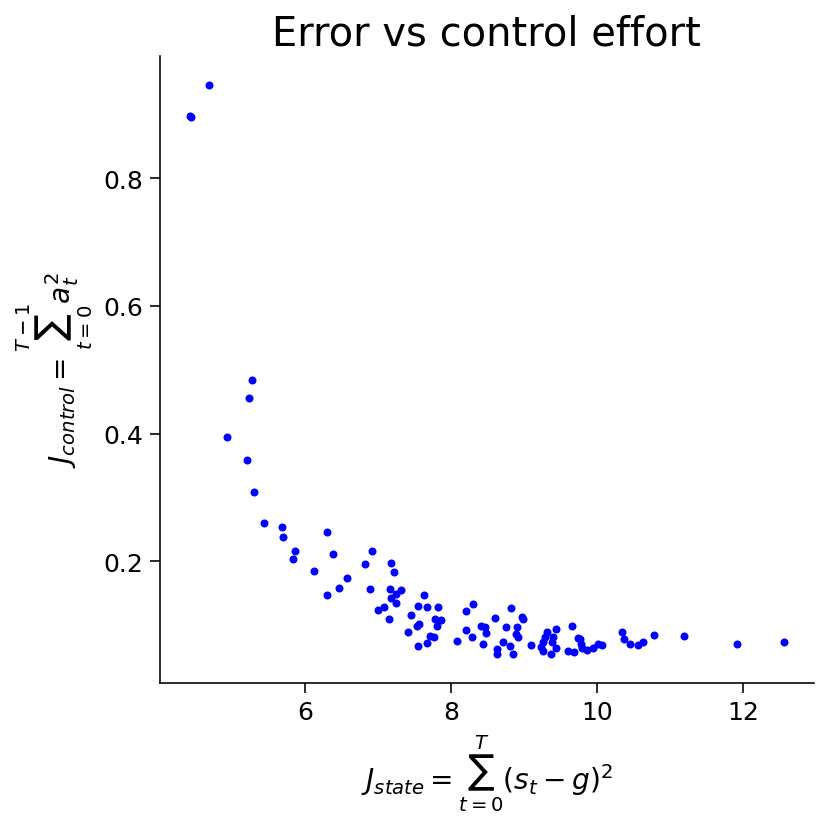

In [14]:
#@title << Run cell to visualize the tradeoff between state and control cost
def calculate_plot_costs():
    D, B, noise_var, T, ini_state = 0.9, 2., 0.1, 50, 2.
    rho_array = np.linspace(0.2, 40, 100)
    J_state = np.zeros(rho_array.shape)
    J_control = np.zeros(rho_array.shape)
    for i in np.arange(len(rho_array)):
        lqr = LQR(T, ini_state, noise_var)
        L = lqr.control_gain_LQR(D, B, rho_array[i])
        s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)
        J_state[i] = lqr.calculate_J_state(s_lqr) ## Code this up.
        J_control[i] = lqr.calculate_J_control(a_lqr) ## Code this up.

    fig = plt.figure(figsize=(6, 6))
    plt.plot(J_state, J_control, '.b')
    plt.xlabel("$J_{state} = \sum_{t = 0}^{T} (s_{t}-g)^2$", fontsize =14)
    plt.ylabel("$J_{control} = \sum_{t=0}^{T-1}a_{t}^2$" , fontsize =14)
    plt.title("Error vs control effort", fontsize =20)
    plt.show()

calculate_plot_costs()

In Exercise 2.3, you should notice the bottom half of a 'C' shaped curve as the tradeoff between the state cost and the control cost using optimal linear control. If you do not see such a curve, change the minimum and maximum value for $\rho$ in the code above till you do.

For a desired value of the state cost, we cannot reach a lower control cost than the curve in the above plot. Similarly for a desired value of the control cost. This is thus an important curve when designing a system and exploring its control.

For example, if you know that you have a limited amount of fuel, which determines your maximum control cost to be $J_{control}^{max}$. You will be able to show that you will not be able to track your state with a higher accuracy than the corresponding $J_{state}$ as given by the graph above.

---
#Section 3: LQR for tracking a time-varying goal

Video available at https://youtube.com/watch?v=HOoqM7kBWSY


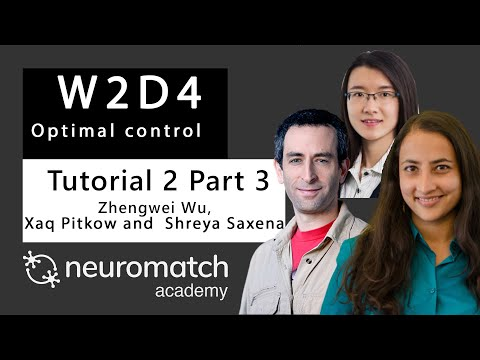

In [15]:
#@title Video: Tracking a moving goal
video = YouTubeVideo(id='HOoqM7kBWSY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In a more realistic situation, the mouse is moving around constantly. Say you were able to predict the movement of the mouse (maybe it's just bouncing from one place to another in a sinusoidal motion). This becomes your goal trajectory $g_t$.

When the target state, denoted as $g_t$, is not $0$, the cost function becomes
$$ J({\bf a}) = \sum_{t = 0}^{T} (s_{t}- g_t) ^2 + \rho \sum_{t=0}^{T-1}(a_{t}-\bar a_t)^2$$
Here, $\bar a_t$ is the desired action based on the goal trajectory, i.e. the controller considers the goal for the next time step, and designs a preliminary control action that gets the state at the next time step to the desired goal. Specifically, without taking into account noise $w_t$, we would like to design $\bar a_t$ such that $s_{t+1}=g_{t+1}$. Thus, from Equation $(1)$,

\begin{eqnarray*}
g_{t+1} &=& Ds_t + B \bar a_t\\
\bar a_{t} &=& \frac{- Ds_t + g_{t+1}}{B}\\
\end{eqnarray*}

The final control action $a_t$ is produced by adding this desired action $\bar a_t$ with the term with the control gain $L_t(s_t - g_t)$.

We will first consider a sinusoidal trajectory to track: $g_t=\sin(2\pi \Omega t/T)$, with $\Omega=5$.

In [16]:
#@title << Helper class for LQR control to desired time-varying goal

class LQR_tracking(LQR):
    def __init__(self, T, ini_state, noise_var, goal):
        super().__init__(T, ini_state, noise_var)
        self.goal = goal

    def dynamics_tracking(self, D, B, L):
        
        s = np.zeros(self.T) # states intialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(self.T) # control intialization
        a_bar = np.zeros(self.T)
        for t in range(self.T - 1):
            a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
            a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        
        return s, a, a_bar

    def calculate_J_state(self,s):
        J_state = np.sum((s-self.g) ** 2)
        return J_state
    
    def calculate_J_control(self, a, a_bar):
        J_control = np.sum((a-a_bar) ** 2) 
        return J_control

### Exercise 3: LQR control to desired time-varying goal
In this excercise, we will design an LQR controller to track a sinusoid function. 

(a) Explore how the system reacts with different values of $\rho$ and process noise variance.

(b) Explore other time-varying functions, such as a step function and ramp.

In [17]:
#@title << Interactive
#@markdown Play around with **`goal_func`** and as well as  **`rho`** and  **`noise_var`**. \\

def simulate_tracking(rho=20., noise_var=0.1, goal_func='sin'):
    D, B, T, ini_state = 0.9, 2., 100, 0.
    if goal_func == 'sin':
        goal = np.sin(np.arange(T) * 2 * np.pi * 5 /T)
    elif goal_func == 'step':
        goal = np.zeros(T)
        goal[int(T/3):] = 1.
    elif goal_func == 'ramp':
        goal = np.zeros(T)
        goal[int(T/3):] = np.arange(T-int(T/3))/(T-int(T/3))

    lqr_time = LQR_tracking(T, ini_state, noise_var, goal)
    L = lqr_time.control_gain_LQR(D, B, rho)
    s_lqr_time, a_lqr_time, a_bar_lqr_time = lqr_time.dynamics_tracking(D, B, L)

    plt.figure(figsize=(13, 5))
    plt.suptitle('LQR Control for time-varying goal', y=1.05)
    plt.subplot(1, 2, 1)
    plot_vs_time(s_lqr_time,'State evolution $s_t$','b',goal)
    plt.subplot(1, 2, 2)
    plot_vs_time(a_lqr_time, 'Action $a_t$', 'b')
    plt.show()

widget=interactive(simulate_tracking, {'manual': True},
                   rho = (0., 40., 10.),
                   noise_var = (0., 1., .2),
                   goal_func = ['sin', 'step', 'ramp']
                   )
widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'

controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

In Exercise 3, you should have noticed that:
* The system follows time varying goals rather well, with little change to the cost function and the control equations.
* The value of $\rho=0$ leads to noise in the first part of the time series. Here, we see that the control cost in fact acts as a regularizer.
* Larger values of the process noise variance lead to a higher MSE between the state and the desired goal. 

---
#Section 4: Control of an partially observed state using a Linear Quadratic Gaussian (LQG) controller

Video available at https://youtube.com/watch?v=c_D7iDLT_bw


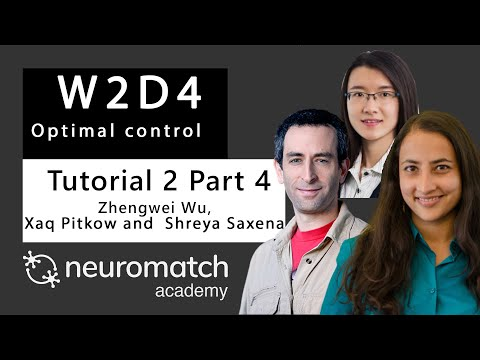

In [18]:
#@title Video: Linear Quadratic Gaussian (LQG) Control
video = YouTubeVideo(id='c_D7iDLT_bw', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Here we consider the case where the controller does not have full access to the state, which is often the case in practice. For example, your jet pack in space may be controlled from earth! 
Specifically, noisy measurements $m_t$ of the state $s_t$ are taken, and the controller needs to (1) estimate the state, and (2) design the action based on this estimate. 
In fact, the separation principle tells us that it is optimal to do (1) and (2) separately. This makes our problem much easier, since we already know how to do each step.  

1) *State Estimation*  
Can we recover the state from the measurement? 
From yesterday's lecture, it is known that the states $\hat{s}_t$ can be estimated from the measurements $m_t$ using the __Kalman filter__. 

2) *Design Action*  
We have just learnt about the LQR controller in Exercises 2 and 3, which helps us design an action based on the state. The separation principle tells us that it is sufficient to replace the use of the state in LQR with the *estimated* state, i.e.

$$a_t = L_t \hat s_t$$

The state dynamics will then be:
$$s_{t+1} = D s_t + B a_t + w_t$$
where $w_t$ is the process noise, and the observation / measurement is:
$$ y_t = C x_t + v_t$$ 
with $v_t$ being the measurement noise. 

The combination of (1) state estimation and (2) action design using LQR is known as a linear quadratic gaussian (LQG). Yesterday, you have completed the code for Kalman filter.  Based on that, you will code up the LQG controller. Here, the goal $g=0$.


### Exercise 4.1: Implement the Kalman filter in conjunction with a linear closed-loop controller (LQG Control)
In the `MyKalmanFilter` class, the method `def filter_control` implements filtering in closed-loop feedback. It is a combination of generating samples (states $s_t$) and filtering (generating state estimates $\hat s_t$), as you have seen in yesterday's tutorial. The only difference from yesterday is that today's Kalman filter is in closed loop with the controller. Thus, each $s_{t+1}$ gets an input $a_t$, which itself depends on the state estimate of the last time step $\hat s_t$.

Below you find the code snipets for the Kalman filter in closed loop (`MyKalmanFilter`) class that provide you an insight in action update (`control_policy_LQG`) and state estimation (`state_dynamics_LQG`). Please feel free to inspect the helper functions and classes for the details.


You should have seen the next cell containing `MyKalmanFilter` class yesterday, with the exception of the controller acting on the state estimate in feedback, using the methods/equations you will find below.

In [19]:
#@title << Helper code for MyKalmanFilter class
 
class MyKalmanFilter():
    def __init__(self, n_dim_state, n_dim_obs, transition_matrices, transition_covariance, observation_matrices,
                observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        """
        @param n_dim_state: dimension of the latent variables
        @param n_dim_obs: dimension of the observed variables
        @param transition_matrices: D 
        @param transition_covariance: process noise
        @param observation_matrices: C
        @param observation_covariance: measurement noise
        @param initial_state_mean: initial state estimate
        @param initial_state_covariance: initial estimate on state variance
        @param control_matrices: B 
        """
        self.n_dim_state = n_dim_state 
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = transition_matrices 
        self.transition_covariance = transition_covariance  
        self.observation_matrices = observation_matrices 
        self.observation_covariance = observation_covariance 
        self.initial_state_mean = initial_state_mean 
        self.initial_state_covariance = initial_state_covariance 
        
        self.control_matrices = control_matrices 
        
    def filter_control(self, n_timesteps, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering with a controller in feedback
        @param n_timesteps: length of the data sample
        @param control_gain: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
        @output: filtered_state_means: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
        @output: filtered_state_covariances: a numpy array whose dimension is [n_timesteps, self.n_dim_state, self.n_dim_state]
        @output: latent_state: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
        @output: observed_state: a numpy array whose dimension is [n_timesteps, self.n_dim_obs]
        @output: control: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
        """

        # validate inputs
        # assert observed_dim == self.n_dim_obs
        
        n_example = n_timesteps
        observed_dim = self.n_dim_obs
        latent_state = []
        observed_state = []
        control = []
        
        current_latent_state = self.initial_state_mean #initial_state
        control.append(self.initial_state_mean)
        latent_state.append(current_latent_state)
        observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))



        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])


        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            
            for i in range(1, n_example):                
                ## Use the code in Exercise 4.1 to get the current action
                current_action = control_policy_LQG(self,current_state_mean,control_gain[i])
                control.append(current_action)    
                

                ## Use the code in Exercise 4.1 to update the state
                current_latent_state = state_dynamics_LQG(self,current_latent_state, current_action)
                latent_state.append(current_latent_state)

                # use observation_matrices and observation_covariance to calculate next observed state
                observed_state.append(np.dot(self.observation_matrices, current_latent_state
                                            ) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))
               
                current_observed_data = observed_state[-1]
                

                # run a single step forward filter
                # prediction step
                
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                             ) + np.dot(self.control_matrices, current_action)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
        
     
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation) 
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
                # new
                # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
                #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#             #################################################################################
        
        filtered_state_means = np.squeeze(np.array(filtered_state_means))
        filtered_state_covariances = np.squeeze(np.array(filtered_state_covariances))
        latent_state = np.squeeze(np.array(latent_state))
        observed_state = np.squeeze(np.array(observed_state))
        control = np.squeeze(np.array(control))
        
        
        return filtered_state_means, filtered_state_covariances, latent_state, observed_state, control


    def plot_state_vs_time(self, n_timesteps, control_gain, title, use_myfilter=True, goal=None):
        filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = self.filter_control(
            n_timesteps, control_gain)

        fig = plt.figure(figsize=(12, 4))
        plt.suptitle(title, y=1.05)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

        ax0 = plt.subplot(gs[0])
        ax0.plot(latent,filtered_state_means_impl, 'b.')
        ax0.set_xlabel('latent state')
        ax0.set_ylabel('estimated state')
        ax0.set_aspect('equal')

        ax1 = plt.subplot(gs[1])
        ax1.plot(latent, 'b', label = 'latent state')
        ax1.plot(filtered_state_means_impl, 'r', label = 'estimated state')
        if goal is not None:
          ax1.plot(goal, 'm', label = 'goal')
        ax1.set_xlabel('time')
        ax1.set_ylabel('state')
        ax1.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [20]:
# inspect the 'control_policy_LQG' and 'state_dynamics_LQG' methods:

def control_policy_LQG(self, mean_estimated_state, control_gain):
    current_action =  control_gain * mean_estimated_state
    return current_action

def state_dynamics_LQG(self, current_latent_state, current_action):

    current_latent_state = np.dot(self.transition_matrices, current_latent_state)\
                         + np.dot(self.control_matrices, current_action)\
                         + np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                         self.transition_covariance)
    return current_latent_state


Take a look at the helper code for the `MyKalmanFilter` class above. In the following exercises, we will use the same notation that we have been using in this tutorial, but convert it to the notation in the `MyKalmanFilter` class under the hood.

In [21]:
#@title << Interactive
#@markdown Explore the output of the Kalman filter with no control input by varrying **`C`** , **`process_noise`** and **`measurement_noise`**. \\

def simulate_kf_no_control(D=0.9, B=2., C=1., L=0., T=50, ini_state=5,
                           proc_noise = 0.1, meas_noise = 0.2):

    control_gain = np.ones(T)*L

    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D 
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B

    my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                        transition_covariance, observation_matrices,
                        observation_covariance, initial_state_mean,
                        initial_state_covariance, control_matrices)

    my_kf.plot_state_vs_time(n_timesteps, control_gain,
                             'State estimation with KF (no control input)')

widget=interactive(simulate_kf_no_control, {'manual': True},
                    D = fixed(.95),
                    B = fixed(2.),
                    C = (0., 3., 1.),
                    proc_noise = (0., 1., .1),
                    meas_noise = (0.1, 1., .1),
                    T = fixed(50),
                    L = fixed(0),
                    ini_state = fixed(5.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

### Exercise 4.2: Visualize the output of an LQG controller, while varying the control gain
Now let's implement the Kalman filter with closed-loop feedback with the controller. We will first use an arbitary control gain and a fixed value for measurement noise. We will then use the control gain from the LQR for optimal performance, with varying values for $\rho$.

(a) Visualize the system dynamics $s_t$ in closed-loop control with an arbitrary constant control gain. Vary this control gain.

(b) Vary $\rho$ to visualize the output of the optimal LQG controller. Here, we will use an optimal *constant* control gain, which is optimal in the case of an infinite time horizon (get to the goal and stay there forever).

In [22]:
#@title << Interactive
#@markdown Explore the output of the Kalman filter by varrying controller gain **`L`** as well as **`C`** , **`process_noise`** and **`measurement_noise`**. \\

def simulate_kf_with_control(D=0.9, B=2., C=1., L=-0.1, T=50, ini_state=5,
                           proc_noise = 0.1, meas_noise = 0.2):

    control_gain = np.ones(T)*L

    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D 
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B

    my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                        transition_covariance, observation_matrices,
                        observation_covariance, initial_state_mean,
                        initial_state_covariance, control_matrices)

    my_kf.plot_state_vs_time(n_timesteps, control_gain, goal = np.zeros(T),
                            title='State estimation with KF (controller gain = {})'.format(L))

widget=interactive(simulate_kf_with_control, {'manual': True},
                    D = fixed(.9),
                    B = fixed(2.),
                    C = (0., 3., 1.),
                    proc_noise = (0., 1., .1),
                    meas_noise = (0.1, 1., .1),
                    T = fixed(50),
                    L = (-0.5, 0., .1),
                    ini_state = fixed(5.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

Now let's see the performance of the LQG controller. We will use an LQG controller gain, where the control gain is from a system with an infinite-horizon. In this case, the optimal control gain turns out to be a constant. 

Vary the value of $\rho$ from $0$ to large values, to see the effect on the state.

In [23]:
#@title << Helper function for LQG
class LQG(MyKalmanFilter, LQR):
    def __init__(self, T, n_dim_state, n_dim_obs, 
                 transition_matrices, transition_covariance, observation_matrices,
                 observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        MyKalmanFilter.__init__(self,n_dim_state, n_dim_obs, 
                                transition_matrices, transition_covariance, 
                                observation_matrices,observation_covariance, 
                                initial_state_mean, initial_state_covariance, control_matrices)
        LQR.__init__(self,T, initial_state_mean, transition_covariance)   

    def control_gain_LQR_infinite(self, rho):
        control_gain_LQR_finite = self.control_gain_LQR(self.transition_matrices, self.control_matrices, rho)
        return control_gain_LQR_finite[0]


In [24]:
#@title << Interactive
#@markdown Explore the output of the Kalman filter with LQG control input by varrying **`rho`** . \\

def simulate_kf_with_lqg(D=0.9, B=2., C=1., T=50, ini_state=5,
                           proc_noise=0.1, meas_noise=0.2, rho=1.):

    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D 
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B

    my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                        transition_covariance, observation_matrices,
                        observation_covariance, initial_state_mean,
                        initial_state_covariance, control_matrices)
    
    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs, 
            transition_matrices, transition_covariance, observation_matrices,
            observation_covariance, initial_state_mean, initial_state_covariance,
            control_matrices)

    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)

    lqg.plot_state_vs_time(n_timesteps, control_gain_lqg, goal = np.zeros(T),
                        title='State estimation with KF (LQG controller)')

widget=interactive(simulate_kf_with_lqg, {'manual': True},
                    D = fixed(.9),
                    B = fixed(2.),
                    C = fixed(1.),
                    proc_noise = fixed(.1),
                    meas_noise = fixed(.2),
                    T = fixed(50),
                    ini_state = fixed(5.),
                    rho=(0., 5., 1.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

### Exercise 4.3: How does the process noise and the measurement noise influence the controlled state and desired action?

Process noise $w_t$ and measurement noise $v_t$ have very different effects on the controlled state. 

(a) To visualize this, play with the sliders to get an intuition for how process noise and measurement noise influences the controlled state. How are these two sources of noise different?

(b) Next, for varying levels of process noise and measurement noise (note that the control policy is exactly the same for all these values), plot the mean squared error (MSE) between state and the goal, as well as the control cost. What do you notice?


In [25]:
#@title << Interactive
#@markdown Explore the output of the Kalman filter with LQG control input by varrying **`process_noise`** and **`measurement_noise`** . \\

def lqg_slider(D=0.9, B=2., C=1., T=50, ini_state=5,
                           proc_noise=2.9, meas_noise=0., rho=1.):

    # Format the above variables into a format acccepted by the Kalman Filter
    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D 
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B
    rho = 1

    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs, 
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)
    
    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)
    lqg.plot_state_vs_time(n_timesteps, control_gain_lqg, goal = np.zeros(n_timesteps),
                           title='State estimation with KF (LQG controller)')

widget=interactive(lqg_slider, {'manual': True},
                    D = fixed(.9),
                    B = fixed(2.),
                    C = fixed(1.),
                    proc_noise = (0., 3., .1),
                    meas_noise = (0.1, 3., .1),
                    T = fixed(50),
                    ini_state = fixed(5.),
                    rho=fixed(1.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

As you increase the process noise, you will notice that it becomes more difficult to keep the state close to the goal $g=0$, even though we may have very little measurement noise (thus can estimate the state exactly).

On the other hand, as you increase the measurement noise, you will notice that it is harder to estimate the states, and this also may make it harder to keep the state close to the goal $g=0$. Which has a larger effect? What effect does this have on the required action $a_t$? We will quantify these in the next plot.

### Quantifying how the state cost and control cost depend on the different sources of noise

We can now quantify how the state cost and control costs changes when we change the process and measurement noise. 

In [26]:
#@title << Run cell to quantify the dependence of state and control cost on process and measurement noise (takes ~20 seconds)
D = 0.9 # state parameter 
B = 2   # control parameter
C = 1   # measurement parameter
noise_var = 0.1
T = 200  # time horizon
ini_state = 5      # initial state
process_noise_var = 0.1   # process noise
measurement_noise_var = 0.2     # measurement noise
rho = 1

# Format the above variables into a format acccepted by the Kalman Filter
n_dim_state = 1
n_dim_obs = 1
n_timesteps = T

transition_matrices = np.eye(n_dim_state) * D 
transition_covariance = np.eye(n_dim_obs) * noise_var # process noise
observation_matrices = np.eye(n_dim_state) * C
observation_covariance = np.eye(n_dim_obs) * measurement_noise_var
initial_state_mean = np.ones(n_dim_state) * ini_state
initial_state_covariance = np.eye(n_dim_state) * .01
control_matrices = np.eye(n_dim_state) * B

# Implement LQG control over n_iter iterations, and record the MSE between state and goal
MSE_array_N_meas = []
MSE_array_N_proc = []
Jcontrol_array_N_meas = []
Jcontrol_array_N_proc = []
n_iter = 10
meas_noise_array = np.linspace(0,3,20)
proc_noise_array = np.linspace(0.1,3,20)

for i in range(n_iter):
    MSE_array = np.zeros(proc_noise_array.shape)
    Jcontrol_array = np.zeros(meas_noise_array.shape)
    for i in range(len(proc_noise_array)):

        transition_covariance = np.eye(n_dim_obs)  * proc_noise_array[i]
        observation_covariance = np.eye(n_dim_obs) * measurement_noise_var
        lqg = LQG(n_timesteps, n_dim_state, n_dim_obs, 
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)
        
        control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)  # Get the control gain
        filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = lqg.filter_control(
            n_timesteps, control_gain_lqg)
        MSE_array[i] = lqg.calculate_J_state(latent)
        Jcontrol_array[i] = lqg.calculate_J_control(control)

    MSE_array_N_proc.append(MSE_array)
    Jcontrol_array_N_proc.append(Jcontrol_array)


    MSE_array = np.zeros(meas_noise_array.shape)
    Jcontrol_array = np.zeros(meas_noise_array.shape)
    for i in range(len(meas_noise_array)):

        observation_covariance = np.eye(n_dim_obs)  * meas_noise_array[i]
        transition_covariance = np.eye(n_dim_obs) * noise_var
        lqg = LQG(n_timesteps, n_dim_state, n_dim_obs, 
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)
        
        control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)  # Get the control gain
        filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = lqg.filter_control(
            n_timesteps, control_gain_lqg)
        MSE_array[i] = lqg.calculate_J_state(latent)
        Jcontrol_array[i] = lqg.calculate_J_control(control)

    MSE_array_N_meas.append(MSE_array)
    Jcontrol_array_N_meas.append(Jcontrol_array)       
    
MSE_array_proc_mean = np.mean(np.array(MSE_array_N_proc), axis = 0)
MSE_array_proc_std = np.std(np.array(MSE_array_N_proc), axis = 0)
MSE_array_meas_mean = np.mean(np.array(MSE_array_N_meas), axis = 0)
MSE_array_meas_std = np.std(np.array(MSE_array_N_meas), axis = 0)

Jcontrol_array_proc_mean = np.mean(np.array(Jcontrol_array_N_proc), axis = 0)
Jcontrol_array_proc_std = np.std(np.array(Jcontrol_array_N_proc), axis = 0)
Jcontrol_array_meas_mean = np.mean(np.array(Jcontrol_array_N_meas), axis = 0)
Jcontrol_array_meas_std = np.std(np.array(Jcontrol_array_N_meas), axis = 0)


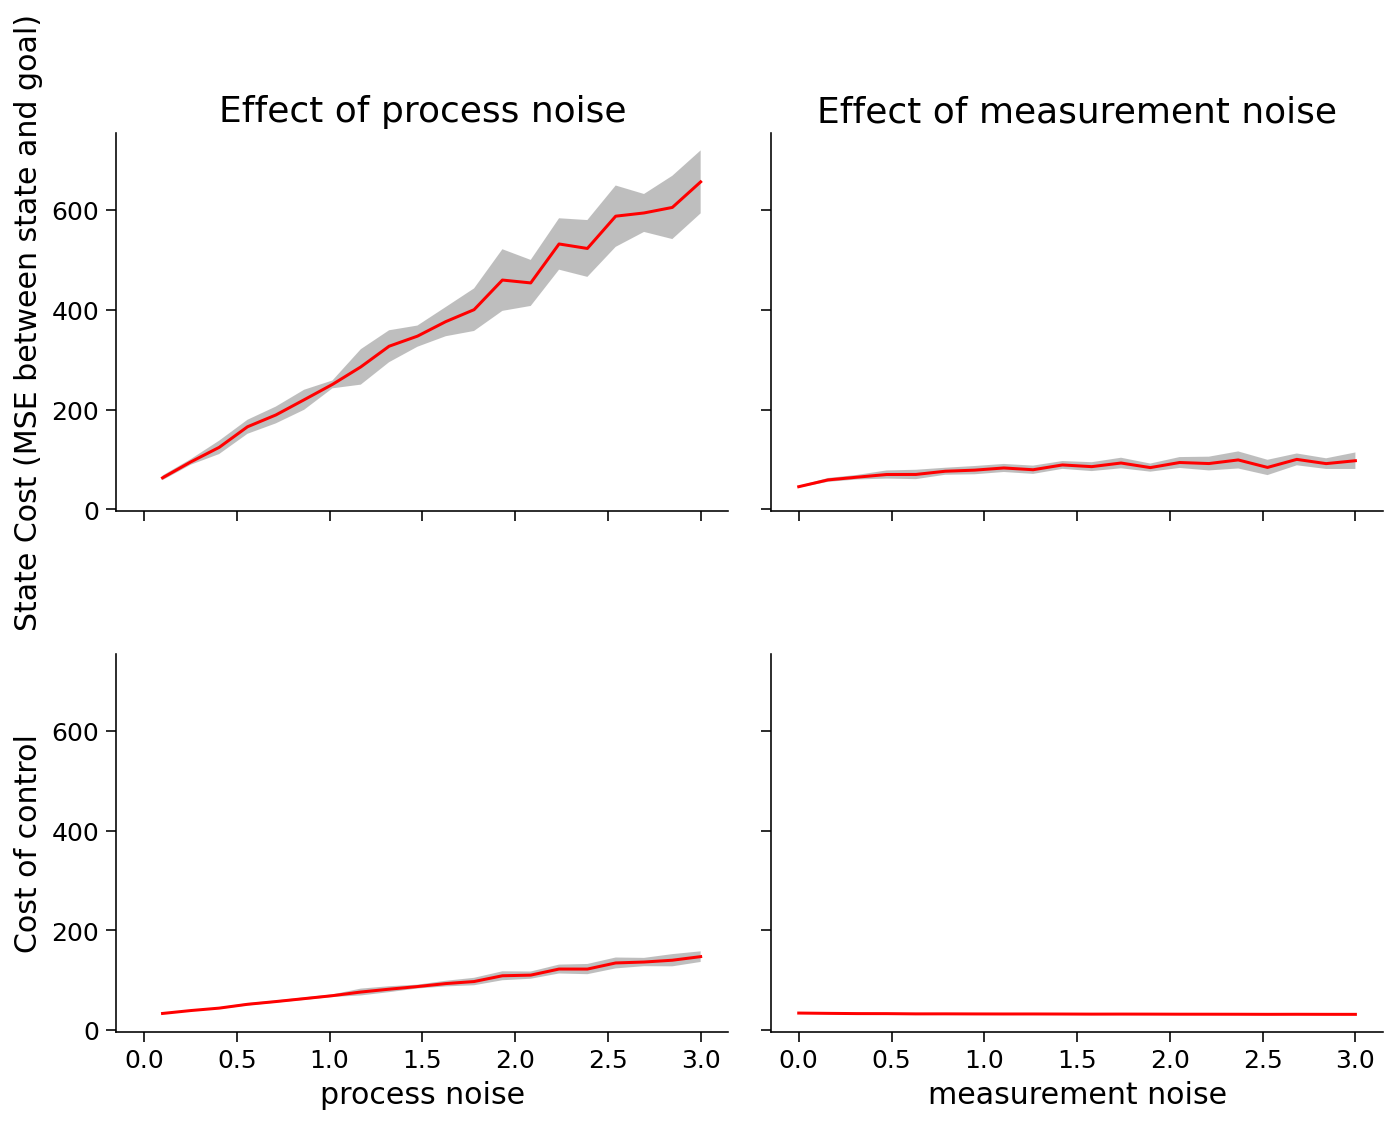

In [27]:
#@title << Run cell to visualize the quantification
f, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))

axs[0,0].plot(proc_noise_array, MSE_array_proc_mean, 'r-')
axs[0,0].fill_between(proc_noise_array, MSE_array_proc_mean+MSE_array_proc_std, 
                MSE_array_proc_mean-MSE_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[0,0].set_title('Effect of process noise')
axs[0,0].set_ylabel('State Cost (MSE between state and goal)')

axs[0,1].plot(meas_noise_array, MSE_array_meas_mean, 'r-')
axs[0,1].fill_between(meas_noise_array, MSE_array_meas_mean+MSE_array_meas_std, 
                MSE_array_meas_mean-MSE_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[0,1].set_title('Effect of measurement noise')

axs[1,0].plot(proc_noise_array, Jcontrol_array_proc_mean, 'r-')
axs[1,0].fill_between(proc_noise_array, Jcontrol_array_proc_mean+Jcontrol_array_proc_std, 
                Jcontrol_array_proc_mean-Jcontrol_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[1,0].set_xlabel('process noise')
axs[1,0].set_ylabel('Cost of control')

axs[1,1].plot(meas_noise_array, Jcontrol_array_meas_mean, 'r-')
axs[1,1].fill_between(meas_noise_array, Jcontrol_array_meas_mean+Jcontrol_array_meas_std, 
                Jcontrol_array_meas_mean-Jcontrol_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[1,1].set_xlabel('measurement noise')
plt.show()


In fact, while both sources of noise have an effect on the controlled state, the process noise has a much larger effect. As the process noise $w_t$ increases, both state cost (MSE between state and goal, $\sum_{t=1}^T(s_t-g)^2$ ) and the control cost ($\sum_{t=1}^{T-1}a_t^2$) increase drastically. You can get an intuition as to why using the sliders in the plot before this. Moreover, as the process noise gets larger, you will need to put in more effort to keep the system close to the goal. 

The measurement noise $v_t$ also has an effect on the accuracy of the controlled state. As this noise increases, the MSE between the state and goal increases. The cost of control in this case remains fairly constant with increasing levels of measurement noise.